## Setup and Dataset Loading

In [0]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [0]:
zip_path = keras.utils.get_file('jena_climate_2009_2016.csv.zip',
                                'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
                                extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [0]:
df = pd.read_csv(csv_path)

In [4]:
df.head(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [0]:
def univariate_dataset(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) + target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [0]:
TRAIN_SPLIT = 300000
tf.random.set_seed(13)

## Univariate Time Series Forecasting

In [7]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head(5)

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

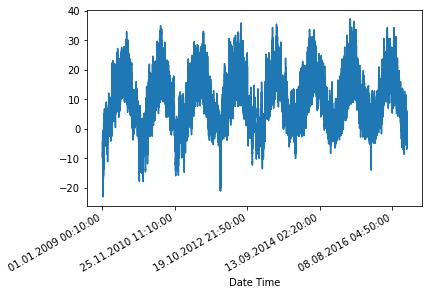

In [8]:
uni_data.plot(subplots = True)
plt.show()

In [0]:
uni_data = uni_data.values

In [0]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data - uni_train_mean)/uni_train_std

In [0]:
univariate_past_history = 20
univariate_future_target = 0

X_train_uni, y_train_uni = univariate_dataset(uni_data, 0, TRAIN_SPLIT, univariate_past_history, univariate_future_target)
X_val_uni, y_val_uni = univariate_dataset(uni_data, TRAIN_SPLIT, None, univariate_past_history, univariate_future_target)

In [12]:
print('Single window of past history')
print(X_train_uni[0])
print('\n Target Temperature to predict')
print(y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target Temperature to predict
-2.1041848598100876


In [0]:
def create_time_steps(length):
    return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future*5)+2])
    plt.xlabel('Time Step')
    return plt.show()

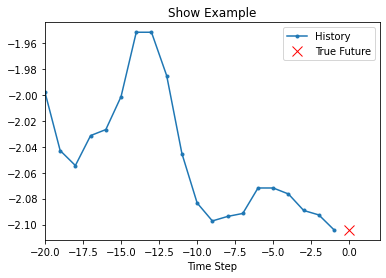

In [15]:
show_plot([X_train_uni[0], y_train_uni[0]], 0, 'Show Example')

In [0]:
# Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.
# Incorporating a baseline

def baseline(history):
    return np.mean(history)

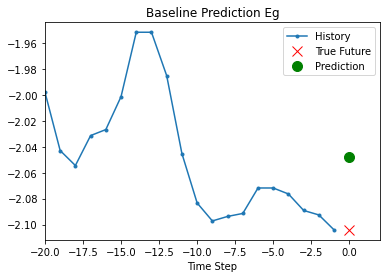

In [17]:
show_plot([X_train_uni[0], y_train_uni[0], baseline(X_train_uni[0])], 0, 'Baseline Prediction Eg')

### LSTM based prediction

In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((X_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BATCH_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((X_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [19]:
lstm_model = keras.Sequential([
                               keras.layers.LSTM(8, input_shape=X_train_uni.shape[-2:]),
                               keras.layers.Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [20]:
for x, y in val_univariate.take(1):
    print(lstm_model.predict(x).shape)

(256, 1)


In [21]:
lstm_model.fit(train_univariate, epochs=10, steps_per_epoch=200, validation_data=val_univariate, validation_steps=50, verbose=1)

Epoch 1/10
200/200 [==============================] - 2s 10ms/step - loss: 0.4752 - val_loss: 0.0568
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 0.2061 - val_loss: 0.0175
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0552 - val_loss: 0.0065
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0611 - val_loss: 0.0046
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0161 - val_loss: 0.0033
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0184 - val_loss: 0.0036
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0100 - val_loss: 0.0025
Epoch 8/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0099 - val_loss: 0.0023
Epoch 9/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0051 - val_loss: 0.0021
Epoch 10/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0118 - val_loss: 0.002

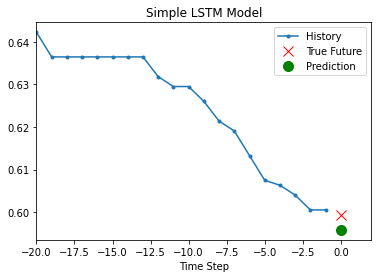

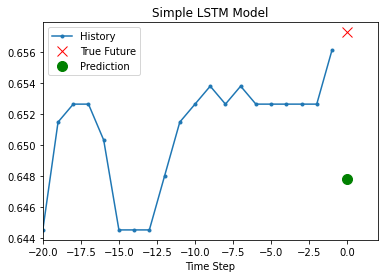

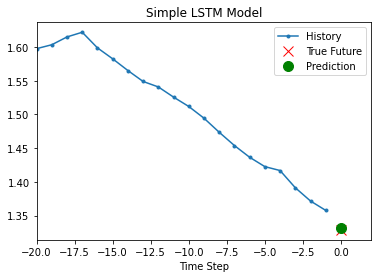

In [22]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(), lstm_model.predict(x)[0]], 0, 'Simple LSTM Model')

## Multivariate Time Series Forecasting

### Data Cleaning

In [23]:
features_considered = ['p (mbar)','T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
features.head(5)

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


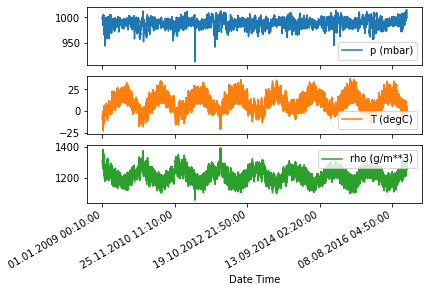

In [24]:
features.plot(subplots=True)
plt.show()

In [0]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean()
data_std = dataset[:TRAIN_SPLIT].std()

dataset = (dataset - data_mean)/data_std

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
    
    return np.array(data), np.array(labels)

### Single Step Predictions

In [0]:
past_history = 720
future_target = 72
STEP = 6

X_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0, TRAIN_SPLIT, past_history, future_target, STEP, single_step=True)
X_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1], TRAIN_SPLIT, None, past_history, future_target, STEP, single_step=True)

In [28]:
print('Single Window of past history: {}'.format(X_train_single[0].shape))

Single Window of past history: (120, 3)


In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((X_train_single, y_train_single))
val_data_single = tf.data.Dataset.from_tensor_slices((X_val_single, y_val_single))

train_data_single = train_data_single.cache().batch(BATCH_SIZE).shuffle(BUFFER_SIZE).repeat()
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [30]:
single_step_model = keras.Sequential([
                                      keras.layers.LSTM(32, input_shape=X_train_single.shape[-2:]),
                                      keras.layers.Dense(1)
])
single_step_model.compile(optimizer='rmsprop', loss='mae')
single_step_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4608      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [31]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [32]:
single_step_history = single_step_model.fit(train_data_single, epochs=10, steps_per_epoch=200, validation_data=val_data_single, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 5s 26ms/step - loss: 0.0554 - val_loss: 0.0358
Epoch 2/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0230 - val_loss: 0.0202
Epoch 3/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0185 - val_loss: 0.0156
Epoch 4/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0174 - val_loss: 0.0288
Epoch 5/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0165 - val_loss: 0.0069
Epoch 6/10
200/200 [==============================] - 5s 26ms/step - loss: 0.0149 - val_loss: 0.0072
Epoch 7/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0150 - val_loss: 0.0324
Epoch 8/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0141 - val_loss: 0.0266
Epoch 9/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0145 - val_loss: 0.0162
Epoch 10/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0137 - val_lo

In [0]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'g', label="Validation Loss")
    plt.title(title)
    plt.legend()

    plt.show()

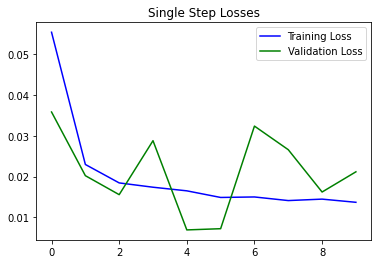

In [34]:
plot_train_history(single_step_history, 'Single Step Losses')

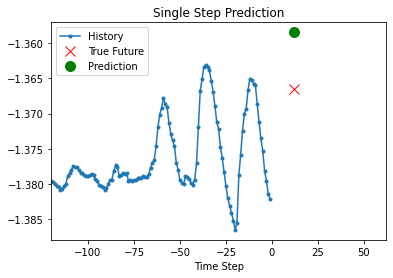

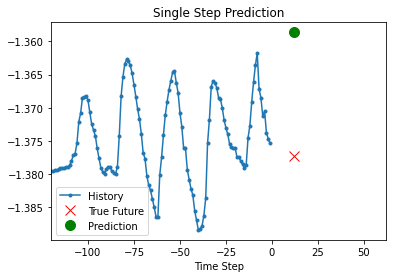

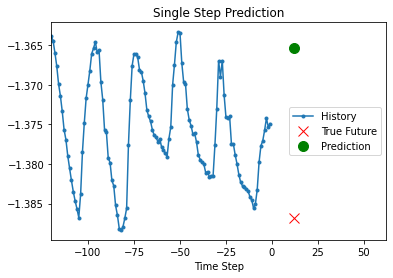

In [35]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:,1].numpy(), y[0].numpy(), single_step_model.predict(x)[0]], 12, 'Single Step Prediction')

### Multi Step Predictions

In [0]:
future_target = 72

X_train_multi, y_train_multi = multivariate_data(dataset, dataset[:,1], 0, TRAIN_SPLIT, past_history, future_target, STEP)
X_val_multi, y_val_multi = multivariate_data(dataset, dataset[:,1], TRAIN_SPLIT, None, past_history, future_target, STEP)

In [0]:
print('Single Window of past history: {}'.format(X_train_multi[0]))
print('\nSingle Window shape of past history: {}'.format(X_train_multi[0].shape))
print('\nTarget Temperature to predict: {}'.format(y_train_multi[0]))
print('\nTarget Temperature shape to predict: {}'.format(y_train_multi[0].shape))

In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((X_train_multi, y_train_multi))
val_data_multi = tf.data.Dataset.from_tensor_slices((X_val_multi, y_val_multi))

train_data_multi = train_data_multi.cache().batch(BATCH_SIZE).shuffle(BUFFER_SIZE).repeat()
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [0]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12,6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:,1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro', label='Predicted Future')
    plt.legend()
    plt.show()

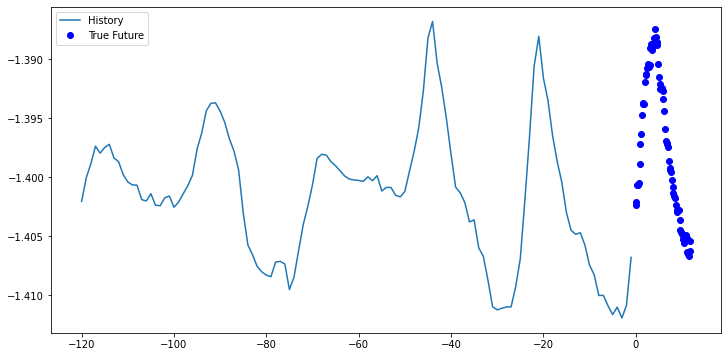

In [40]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [41]:
multi_step_model = keras.Sequential([
                                     keras.layers.LSTM(32, return_sequences=True, input_shape=X_train_multi.shape[-2:]),
                                     keras.layers.LSTM(16, activation='relu'),
                                     keras.layers.Dense(72)
])

multi_step_model.compile(optimizer=keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
multi_step_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 120, 32)           4608      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_2 (Dense)              (None, 72)                1224      
Total params: 8,968
Trainable params: 8,968
Non-trainable params: 0
_________________________________________________________________


In [42]:
for x, y in val_data_multi.take(1):
    print(multi_step_model.predict(x).shape)

(256, 72)


In [43]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=10, steps_per_epoch=200, validation_data=val_data_multi, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 62s 311ms/step - loss: 1290441.0000 - val_loss: 0.5520
Epoch 2/10
200/200 [==============================] - 62s 309ms/step - loss: 0.1259 - val_loss: 0.0329
Epoch 3/10
200/200 [==============================] - 61s 305ms/step - loss: 27974152.0000 - val_loss: 0.0359
Epoch 4/10
200/200 [==============================] - 61s 306ms/step - loss: 0.0507 - val_loss: 0.0749
Epoch 5/10
200/200 [==============================] - 62s 308ms/step - loss: 0.0419 - val_loss: 0.0455
Epoch 6/10
200/200 [==============================] - 61s 303ms/step - loss: 0.0342 - val_loss: 0.0151
Epoch 7/10
200/200 [==============================] - 58s 290ms/step - loss: 0.0319 - val_loss: 0.0126
Epoch 8/10
200/200 [==============================] - 62s 308ms/step - loss: 0.0298 - val_loss: 0.0268
Epoch 9/10
200/200 [==============================] - 61s 307ms/step - loss: 0.0280 - val_loss: 0.0106
Epoch 10/10
200/200 [==============================] - 61s 3

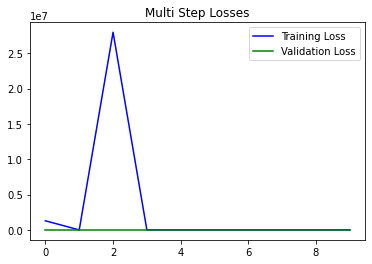

In [44]:
plot_train_history(multi_step_history, 'Multi Step Losses')

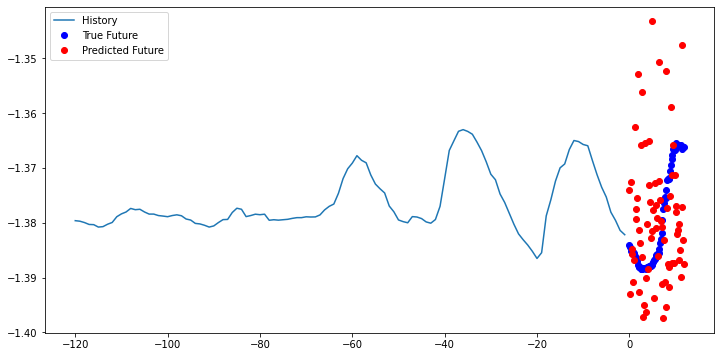

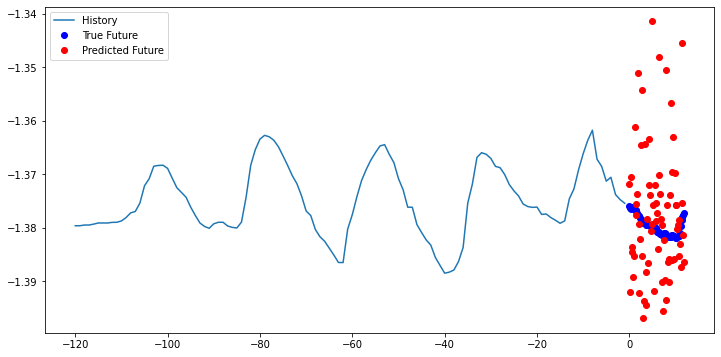

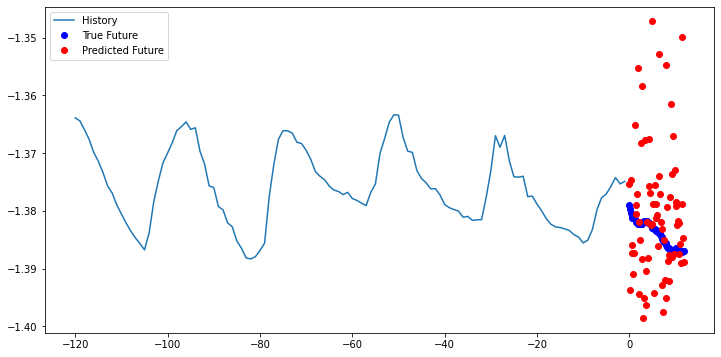

In [45]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])